In [69]:
import sys
from pathlib import Path

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torch
from shapely.errors import TopologicalError
from shapely.geometry import Polygon, MultiPoint
from torchvision.models.detection import maskrcnn_resnet50_fpn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from src.visualization import show_mask, tensor_to_image
from skimage.color import gray2rgb
from nms import nms
from skimage import measure
current_dir = Path(".")
current_dir.absolute()

PosixPath('/home/shamil/PycharmProjects/sartorius_instance_segmentation')

In [70]:
# plt.rcParams["figure.figsize"] = (20,20)

# Global config of configuration
test_images_dir = current_dir / "data" / "test"
weights_dir = current_dir / "weights" / "baseline.ckpt"
device = "cpu"

# Local tunable parameters of evaluation
score_threshold = 0.0  # All predictions would be counted, even with low score
nms_threshold = 0.1  # Overlapping instances will be dropped
mask_threshold = 0.5 # Cut masks by the threshold

In [71]:
preprocess_image = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

In [72]:
## Visualising utils

def display_masks(im, masks):
    im = tensor_to_image(im)
    im = gray2rgb(im[:, :, 0])

    print(im.shape, masks.shape)
    print(masks.sum())

    for mask in masks:
        im[mask==1.] = (255, 0, 0)

    plt.imshow(im)
    plt.show()







In [73]:
"""
    Author: https://github.com/Ulquiorracifa/Ocr2/blob/6bff9aed6493e97bbc0f3e50ce77ed2fa0cc1a0c/fp/TextBoxes/nms.py
    Author: https://github.com/qjadud1994/Text_Detector/blob/0144a8edb1812bcca6189d043e4865337d93a111/Pytorch/nms_poly.py
"""


def polygon_to_array(polygon: Polygon) -> np.array:
    return np.asarray(polygon.exterior.coords)

def polygon_iou(polygon1: Polygon, polygon2: Polygon):
    polygon_pts1 = polygon_to_array(polygon1)
    polygon_pts2 = polygon_to_array(polygon2)

    union_poly = np.concatenate((polygon_pts1, polygon_pts2))
    if not polygon1.intersects(polygon2):  # this test is fast and can accelerate calculation
        iou = 0
    else:
        try:
            inter_area = polygon1.intersection(polygon2).area

            union_area = MultiPoint(union_poly).convex_hull.area
            if union_area == 0:
                return 1

            iou = float(inter_area) / union_area

        except TopologicalError:
            print('shapely.geos.TopologicalError occurred, iou set to 0')
            iou = 0
    return iou


def nms_polygons(polygons: np.array, scores: np.array, iou_threshold: float) -> np.array:
    """ Apply nms to polygons, returns flags, which polygons to leave"""

    indices = sorted(range(len(scores)), key=lambda k: -scores[k])
    box_num = len(polygons)
    nms_flag = np.asarray([True] * box_num)

    for i in range(box_num):
        ii = indices[i]
        if not nms_flag[ii]:
            continue

        for j in range(box_num):
            jj = indices[j]

            if j == i or not nms_flag[jj]:
                continue

            polygon1, polygon2 = polygons[ii], polygons[jj]
            score1, score2 = scores[ii], scores[jj]

            iou = polygon_iou(polygon1, polygon2)

            if iou > iou_threshold:
                if score1 > score2:
                    nms_flag[jj] = False
                if score1 == score2 and polygon1.area > polygon2.area:
                    nms_flag[jj] = False
                if score1 == score2 and polygon1.area <= polygon2.area:
                    nms_flag[ii] = False
                    break

    return nms_flag


def mask_suppression(masks: np.array, scores: np.array, nms_threshold: float):
    polygons = list(map(lambda mask: Polygon(measure.find_contours(image=mask)[0]), masks))
    polygons = np.asarray(polygons)
    indices = nms_polygons(polygons, scores, iou_threshold=nms_threshold)
    return masks[indices]



/home/shamil/PycharmProjects/sartorius_instance_segmentation/data/test/d8bfd1dafdc4.png
{'boxes': tensor([[5.6995e+02, 2.9887e+02, 7.0399e+02, 4.5029e+02],
        [7.0717e+01, 2.9730e-03, 2.2141e+02, 7.5883e+01],
        [5.0755e+02, 4.2367e+02, 6.5824e+02, 5.2000e+02],
        [3.7642e-03, 2.9730e-03, 1.3820e+02, 7.5883e+01],
        [6.1155e+02, 4.2367e+02, 7.0399e+02, 5.2000e+02],
        [2.7873e+02, 4.6021e-03, 4.2942e+02, 1.1749e+02],
        [2.6335e-03, 2.8469e+01, 9.6604e+01, 1.7989e+02],
        [8.3125e+00, 3.1967e+02, 1.5900e+02, 4.7109e+02],
        [1.1232e+02, 2.8469e+01, 2.6301e+02, 1.7989e+02],
        [5.9075e+02, 2.8469e+01, 7.0399e+02, 1.7989e+02],
        [2.0631e-03, 3.1967e+02, 7.5804e+01, 4.7109e+02],
        [8.3125e+00, 4.9269e+01, 1.5900e+02, 2.0069e+02],
        [4.8675e+02, 2.9887e+02, 6.3744e+02, 4.5029e+02],
        [2.7873e+02, 3.1967e+02, 4.2942e+02, 4.7109e+02],
        [2.7873e+02, 2.8469e+01, 4.2942e+02, 1.7989e+02],
        [4.2434e+02, 3.4047e+02,

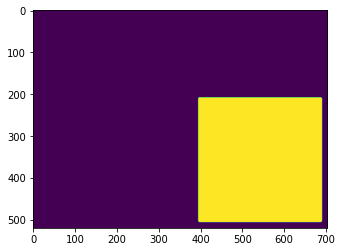

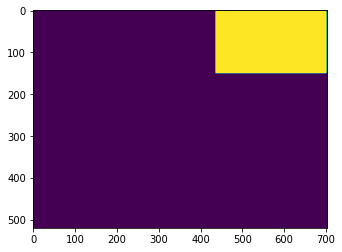

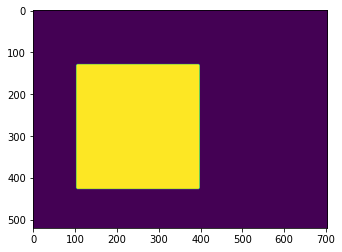

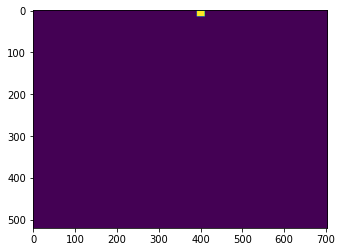

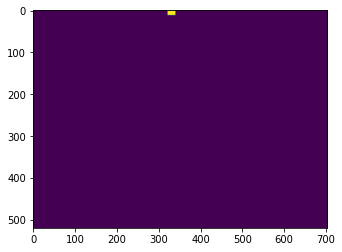

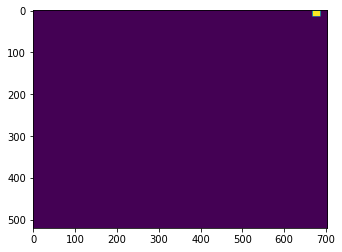

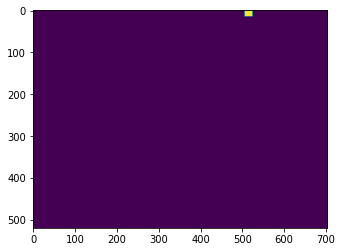

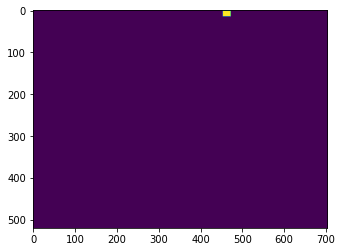

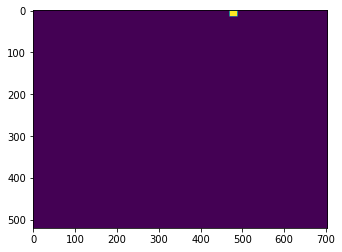

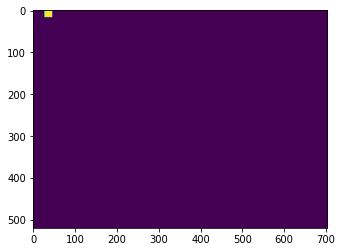

SystemExit: 0

In [74]:
model = maskrcnn_resnet50_fpn(progress=False, num_classes=2)
model.load_state_dict(torch.load(weights_dir, map_location=torch.device("cpu")))
model.to(device)
model.eval()

for image_path in test_images_dir.glob("**/*.png"):
    print(image_path.absolute())
    image = io.imread(str(image_path))
    image = preprocess_image(image=image)['image']
    image = image.to(device)

    with torch.no_grad():
        output = model.forward([image])[0]


    print(output)
    scores = output['scores'].numpy()
    masks = output['masks'].squeeze().numpy()
    masks = (masks >= mask_threshold).astype(int)
    masks = masks[scores >= score_threshold]


    masks = mask_suppression(masks, scores, nms_threshold)


    # Display masks
    for ii in range(10):
        plt.imshow((masks[ii] >= 0.5).astype(int))
        plt.show()

    # display_masks(image, masks)


    sys.exit(0)




